### Imports and database initialization

In [2]:
from sqlalchemy import create_engine, select, func, desc, text, label
from gorillatracker.ssl_pipeline.models import TrackingFrameFeature, Tracking, Video, Camera, VideoRelationship, TrackingRelationship
from sqlalchemy.orm import sessionmaker

from tabulate import tabulate

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

import pandas as pd
import numpy as np
import math

engine = create_engine("sqlite:///../test.db")
session_cls = sessionmaker(bind=engine)

### Number of frames per camera (sorted descending)

In [3]:
stmt = (
    select(Video.camera_id, func.sum(Video.frames).label("count"))
    .group_by(Video.camera_id)
    )

with session_cls() as session:
    result = session.execute(stmt)
    sorted_all = sorted(result.fetchall(), key=lambda x: x[1], reverse=True)
    print(tabulate(sorted_all, headers=result.keys(), tablefmt="psql"))

+-------------+---------+
|   camera_id |   count |
|-------------+---------|
|           6 |   58680 |
|          14 |   33930 |
|          11 |   28440 |
|           8 |   27615 |
|          29 |   23130 |
|          36 |   21780 |
|          25 |   20325 |
|           4 |   19590 |
|          30 |   19215 |
|          18 |   15900 |
|          21 |   12450 |
|          12 |   12375 |
|          10 |    8820 |
|          19 |    8280 |
|           3 |    8160 |
|          31 |    7620 |
|          23 |    7260 |
|          34 |    7260 |
|          17 |    5805 |
|          27 |    4470 |
|          13 |    3810 |
|          32 |    3630 |
|          35 |    3630 |
|           5 |    2595 |
|           1 |    1815 |
|           7 |    1815 |
|          24 |    1815 |
|          26 |    1815 |
|          33 |    1815 |
+-------------+---------+


### Number of Tracking-IDs per Video

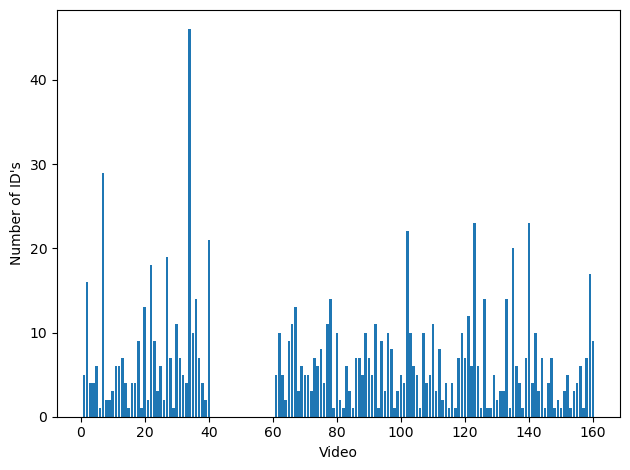

In [4]:
stmt = (
    select(Tracking.video_id, func.count(Tracking.tracking_id).label("count"))
    .group_by(Tracking.video_id)
    )

with session_cls() as session:
    result = session.execute(stmt)
    sorted_all = sorted(result.fetchall(), key=lambda x: x[1], reverse=True)
    
list1, list2 = zip(*sorted_all)
plt.bar(list1, list2)
plt.xlabel("Video")
plt.ylabel("Number of ID's")
plt.tight_layout()
plt.show()

### Number of Tracking-IDs per camera

+-------------+---------+
|   camera_id |   count |
|-------------+---------|
|           1 |    5525 |
|           3 |    3183 |
|           4 |   17534 |
|           5 |    3655 |
|           6 |   70024 |
|           7 |     642 |
|           8 |   27432 |
|          10 |   24920 |
|          11 |   31959 |
|          12 |   10813 |
|          13 |    8262 |
|          14 |   32707 |
|          17 |   13189 |
|          18 |   38147 |
|          19 |   30760 |
|          21 |    9776 |
|          23 |    8159 |
|          24 |     392 |
|          25 |   12983 |
|          26 |    4599 |
|          27 |    1202 |
|          29 |   39387 |
|          30 |   17605 |
|          31 |    1910 |
|          32 |    2653 |
|          33 |     539 |
|          34 |   14986 |
|          35 |    6004 |
|          36 |    5206 |
+-------------+---------+
+-------------+-------------+------------+
|   camera_id |   longitude |   latitude |
|-------------+-------------+------------|
|           1

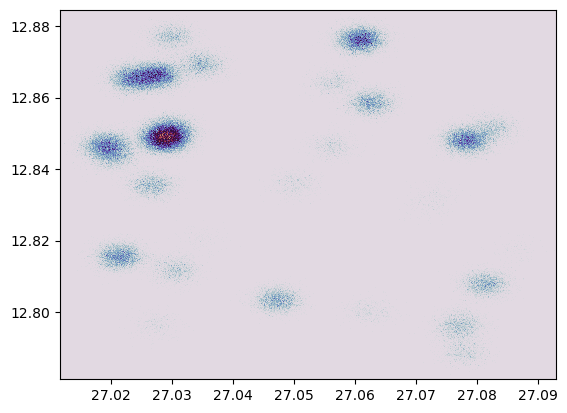

In [6]:
stmt = (
    select(Video.camera_id, func.sum(Tracking.tracking_id).label("count"))
    .join(Tracking, Video.video_id == Tracking.video_id)
    .group_by(Video.camera_id)
    )

with session_cls() as session:
    result = session.execute(stmt)
    all = sorted(result.fetchall(), key=lambda x: x[0])
    print(tabulate(all, headers=result.keys(), tablefmt="psql"))

stmt = (
    select(Camera.camera_id, Camera.longitude, Camera.latitude)
    )

with session_cls() as session:
    result = session.execute(stmt)
    all2 = sorted(result.fetchall(), key=lambda x: x[0])
    print(tabulate(all2, headers=result.keys(), tablefmt="psql"))

mapping = {x : (y,z) for x, y, z in all2}

points = []
for (camera_id2, count) in all:
    for i in range(count):
        (long, lat) = mapping[camera_id2]
        points.append((long + np.random.normal(0, 0.002), lat + np.random.normal(0, 0.002)))

x, y = zip(*points)

plt.hist2d(x,y, bins=1000, cmap="twilight")
plt.show()

### Average number of Tracking-IDs in videos per camera

+-------------+----------+
|   camera_id |    count |
|-------------+----------|
|           3 | 115.231  |
|           4 | 162.083  |
|           6 | 205.426  |
|           8 | 226.444  |
|          11 | 160.854  |
|          12 | 111      |
|          14 |  80.5    |
|          21 | 210.278  |
|          25 | 120.455  |
|          29 | 205.727  |
|          30 |  38.8571 |
|          31 |  85.5385 |
|          36 |  74.0476 |
+-------------+----------+


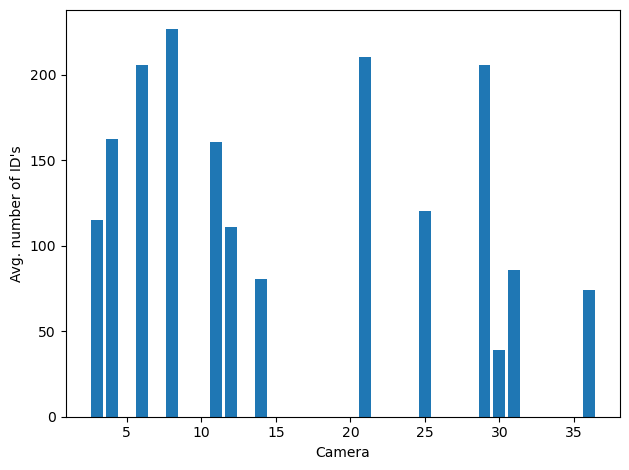

In [10]:
stmt = (
    select(Video.camera_id, func.avg(Tracking.tracking_id).label("count"))
    .join(Tracking, Video.video_id == Tracking.video_id)
    .group_by(Video.camera_id)
    )

with session_cls() as session:
    result = session.execute(stmt)
    all = sorted(result.fetchall(), key=lambda x: x[0])
    print(tabulate(all, headers=result.keys(), tablefmt="psql"))
    
list1, list2 = zip(*all)
plt.bar(list1, list2)
plt.xlabel("Camera")
plt.ylabel("Avg. number of ID's")
plt.tight_layout()
plt.show()

### Number of Videos per Date

+---------------------+
| start_time          |
|---------------------|
| 2022-03-24 06:27:00 |
| 2022-11-14 14:56:00 |
| 2023-01-20 14:08:00 |
| 2022-06-19 09:12:00 |
| 2022-03-23 09:14:00 |
| 2022-02-28 17:02:00 |
| 2022-03-06 11:59:00 |
| 2022-04-03 10:24:00 |
| 2022-04-28 14:45:00 |
| 2022-09-12 15:56:00 |
| 2022-12-13 15:22:00 |
| 2022-05-29 09:35:00 |
| 2022-12-06 06:52:00 |
| 2022-07-06 09:11:00 |
| 2022-03-30 09:06:00 |
| 2022-10-20 09:26:00 |
| 2022-07-11 13:32:00 |
| 2022-05-20 11:03:00 |
| 2022-07-11 16:04:00 |
| 2022-02-26 11:22:00 |
| 2022-03-26 12:46:00 |
| 2022-11-14 15:19:00 |
| 2023-01-20 14:09:00 |
| 2022-06-19 09:26:00 |
| 2022-04-09 13:51:00 |
| 2022-03-01 06:50:00 |
| 2022-03-06 12:10:00 |
| 2022-04-03 10:48:00 |
| 2022-05-04 14:51:00 |
| 2022-09-25 09:31:00 |
| 2023-01-03 11:32:00 |
| 2022-06-19 09:15:00 |
| 2022-12-23 12:18:00 |
| 2022-07-09 11:22:00 |
| 2022-04-03 13:24:00 |
| 2022-11-11 14:18:00 |
| 2022-07-15 09:13:00 |
| 2022-05-20 11:15:00 |
| 2022-07-11 16:

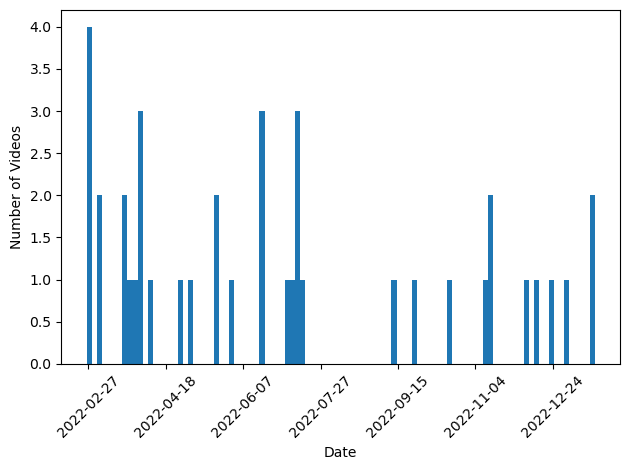

In [12]:
with session_cls() as session:
    result = session.execute(select(Video.start_time))
    all = result.fetchall()
    print(tabulate(all, headers=result.keys(), tablefmt="psql"))
    
all_dates = [mdates.date2num(date[0].date()) for date in all]

fig, ax = plt.subplots()
ax.hist(all_dates, bins=100)
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
plt.xlabel("Date")
plt.ylabel("Number of Videos")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Length of Videos

[(Decimal('20.2500000000'), 1), (Decimal('30.2500000000'), 22), (Decimal('31.2500000000'), 1), (Decimal('32.2500000000'), 1), (Decimal('33.2500000000'), 2), (Decimal('34.2500000000'), 1), (Decimal('37.2500000000'), 1), (Decimal('39.2500000000'), 1), (Decimal('42.2500000000'), 1), (Decimal('45.2500000000'), 1), (Decimal('46.2500000000'), 1), (Decimal('48.2500000000'), 2), (Decimal('49.2500000000'), 1), (Decimal('52.2500000000'), 1), (Decimal('74.2500000000'), 1), (Decimal('77.2500000000'), 1), (Decimal('88.2500000000'), 1)]


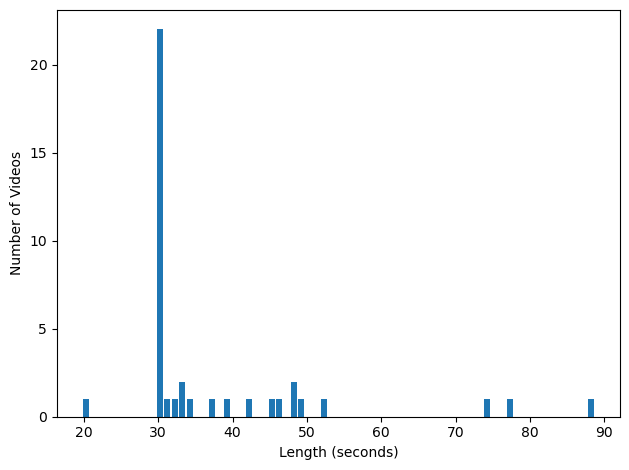

In [11]:
stmt = (
    select((Video.frames / Video.fps).label("duration"), func.count(Video.video_id).label("count"))
    .group_by("duration")
    )

with session_cls() as session:
    result = session.execute(stmt)
    all = result.fetchall()
    print(all)

list1, list2 = zip(*all)
plt.bar(list1, list2)
plt.xlabel("Length (seconds)")
plt.ylabel("Number of Videos")
plt.tight_layout()
plt.show()

### Distribution of Video Recording Times (Daytime)

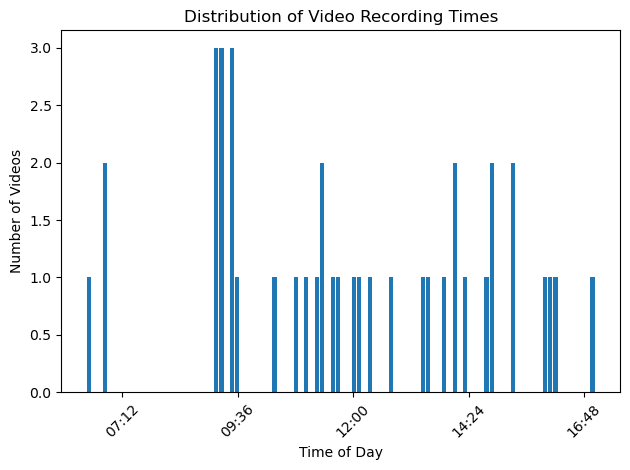

In [40]:
from datetime import datetime

stmt = (
    select(Video.start_time)
)

with session_cls() as session:
    result = session.execute(stmt)
    all = result.fetchall()
    all_times = [mdates.date2num(datetime.combine(datetime.today(), t[0].time())) for t in all]
    
fig, ax = plt.subplots()
ax.hist(all_times, bins=24 * 4, rwidth=0.8)
ax.xaxis.set_major_formatter(DateFormatter("%H:%M"))
plt.xlabel("Time of Day")
plt.ylabel("Number of Videos")
plt.title("Distribution of Video Recording Times")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()